PIPR with STLAB
===============

In addition to the classical rod and cone photoreceptors, the retina also contains [intrinsically photosensetive retinal ganglion cells (ipRGCs)](https://en.wikipedia.org/wiki/Intrinsically_photosensitive_retinal_ganglion_cell). These cells express a photopigment called [melanopsin](https://en.wikipedia.org/wiki/Melanopsin), which is maximally sensetive to short wavelength (blue) light. The ipRGCs project to the suprachiasmatic neucleus and the olivary pretectal nucleus and are involved in 'non-visual' functions, such as circadian photoentrainment and steady-state pupil control. The [post-illumination pupil response (PIPR)](https://iovs.arvojournals.org/article.aspx?articleid=2186454) describes the sustained constriction of the pupil following exposure to short wavelength blue light, and is assumed to be a unique non-invasive signature of melanopsin processing in the human retina. Here we describe a standard protocol for measuring the PIPR with our STLAB-integrating sphere rig.

![](../img/eye_retina.png)


Preparing stimuli
-----------------

As an optimum protocol for exploring melanopsin function, [Park et al. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3175993/) recommend comparing the pupil responses to high intensity (~400 lx) 1-second pulses of short and long wavelength light presented in darkness following a period of dark adaptation. Our first task is therefore to prepare stimuli that fit this specification. We can start by creating a `CalibrationContext(...)` from our calibrated spectrometer data.

In [1]:
import sys
sys.path.insert(0, '../')

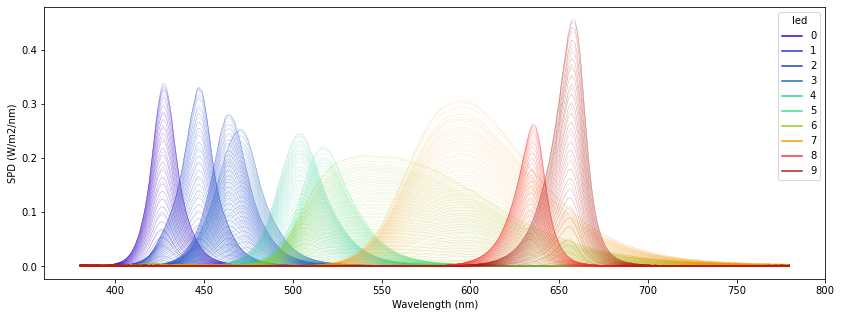

In [3]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()

To confirm which LED is best suited for stimulating melanopsin we can calculate the peak spectral sensitivity for each LED at its maximum intensity setting. 

In [4]:
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    657
dtype: int64

Melanopsin has a peak spectral sensitivity of ~480 nm, which means that LED 3 is our best bet for the melanopic light stimulus. LED 9 is the best choice for the comparison stimulus as it will have the least overlap with the melanopsin spectral sensitivity curve. Having decided which LEDs to use, we can find the intensity settings for the target 400 lux.

In [8]:
blue_led = 3
red_led = 9
target_lux = 800

# find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin()
                                      .values[0])

# find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led, 
                         match_led_intensity=blue_intensity, 
                         target_led=red_led, 
                         match_type='irrad')[1]

It is helpful to visualise the stimuli along with the spectral sensetivity curve for melanopsin.

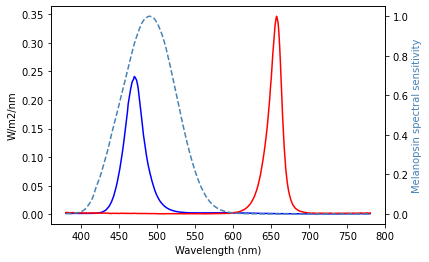

In [7]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(asdf=True, binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')
    
ax2 = ax.twinx()
ax2.plot(sss['Mel'], ls='dashed', c='steelblue')
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

Finally, we can make video files for use with STLAB.

In [9]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity

stlab.pulse_protocol(pulse_spec=blue_spec,
                     pulse_duration=1000, 
                     fname='1s_blue',
                     metadata={'color':'blue'})
stlab.pulse_protocol(pulse_spec=red_spec, 
                     pulse_duration=1000, 
                     fname='1s_red',
                     metadata={'color':'red'})

"1s_blue.dsf" saved in the current working directory.
"1s_red.dsf" saved in the current working directory.


Running the protocol
--------------------

Now we are ready to run the protocol. For optimal results, do this after a 20-minute period of dark adatation.

In [16]:
import os
from time import sleep
from random import shuffle

from pyplr.pupil import PupilCore
from pyplr.stlab import SpectraTuneLab

# make list of stims
stims = ['1s_blue.dsf', '1s_red.dsf'] * 3
shuffle(stims)

# connect to Pupil Core
p = PupilCore()

# connect to stlab
d = SpectraTuneLab(password='83e47941d9e930f6')

# start recording
p.command('R {}'.format(os.getcwd()))

# wait a few seconds
sleep(5.)  

# loop over the list of stims
for stim in stims:
    
    # load video file and create trigger with metadata
    vf = d.load_video_file(stim)
    annotation = {**p.new_annotation('LIGHT_ON'), **vf['metadata']}
    
    # baseline
    sleep(10.)
    
    # set up and start the LightStamper thread 
    lst_future = p.light_stamper(
        threshold=15, annotation=annotation, timeout=6)
    
    # wait 200 ms
    sleep(.2)
    
    # play the video file
    d.play_video_file()
    sleep(60.)  

# finish recording
sleep(5.)   
p.command('r')

STLAB device setup complete...
video file loaded...
Waiting for a light to stamp...
playing video file...
Light stamped on frame.world at 618704.9846330001
video file loaded...
Waiting for a light to stamp...
playing video file...
Light stamped on frame.world at 618775.452681


KeyboardInterrupt: 